## Discretisation with Decision Trees

Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that spans the range of the variable's values. **Supervised discretisation** methods use target information to create the contiguous bins or intervals. Several supervised discretisation methods have been described, see for example the article [Discretisation: An Enabling technique](http://www.public.asu.edu/~huanliu/papers/dmkd02.pdf) for a summary.

However, I have only seen the discretisation using decision trees being used both in Data Science competitions and business settings:

Discretisation using trees was implemented by the winning solution of the KDD 2009 cup: "Winning the KDD Cup Orange Challenge with Ensemble Selection" (http://www.mtome.com/Publications/CiML/CiML-v3-book.pdf).

It is also used in a peer to peer lending company in the UK. See this [blog](https://blog.zopa.com/2017/07/20/tips-honing-logistic-regression-models/) for details of the benefit of using  discretisation using decision trees.


Discretisation with Decision Trees consists of using a decision tree to identify the optimal splitting points that would determine the bins or contiguous intervals: 
- First, it trains a decision tree of limited depth (2, 3  or 4) using the variable we want to discretise to predict the target.
- The original variable values are then replaced by the probability returned by the tree. The probability is the same for all the observations within a single bin, thus replacing by the probability is equivalent to grouping the observations within the cut-off decided by the decision tree.

### Advantages

- The probabilistic predictions returned decision tree are monotonically related to the target.
- The new bins show decreased entropy, this is the observations within each bucket / bin are more similar to themselves than to those of other buckets / bins.
- The tree finds the bins automatically

### Disadvantages
- It may cause over-fitting
- More importantly, some tuning of tree parameters need to be done to obtain the optimal splits (e.g., depth, minimum number of samples in one partition, maximum number of partitions, and a minimum information gain). This it can be time consuming.


Below, I will demonstrate how to perform discretisation with decision trees using the Titanic dataset.

### Titanic dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score

In [2]:
# load the numerical variables of the Titanic Dataset
data = pd.read_csv('titanic.csv', usecols = ['Age', 'Fare', 'Survived'])
data.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


#### Important:

The tree should be built using the training dataset, and then used to replace the same feature in the testing dataset, to avoid over-fitting.

In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data[['Age', 'Fare', 'Survived']],
                                                    data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 3), (268, 3))

### Remove Missing Data

The variable Age contains missing data, that I will fill by extracting a random sample of the variable.

In [4]:
def impute_na(data, variable):
    df = data.copy()
    
    # random sampling
    df[variable+'_random'] = df[variable]
    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

In [5]:
X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

### Age

In [6]:
X_train.head()

,Age,Fare,Survived
857,51.0,26.5500,1
52,49.0,76.7292,1
386,1.0,46.9000,0
124,54.0,77.2875,0
578,14.5,14.4583,0


In [7]:
# example: build Classification tree using Age to predict Survived

tree_model = DecisionTreeClassifier(max_depth=2)
tree_model.fit(X_train.Age.to_frame(), X_train.Survived)
X_train['Age_tree'] = tree_model.predict_proba(X_train.Age.to_frame())[:,1]
X_train.head(10)

,Age,Fare,Survived,Age_tree
857,51.0,26.5500,1,0.370849
52,49.0,76.7292,1,0.370849
386,1.0,46.9000,0,0.516667
124,54.0,77.2875,0,0.370849
578,14.5,14.4583,0,0.818182
549,8.0,36.7500,1,0.516667
118,24.0,247.5208,0,0.370849
12,20.0,8.0500,0,0.370849
157,30.0,8.0500,0,0.370849
127,24.0,7.1417,1,0.370849


In [8]:
X_train.Age_tree.unique()

array([ 0.37084871,  0.51666667,  0.81818182,  0.1       ])

A tree of depth 2, makes 2 splits, therefore generating 4 buckets, that is why we  see 4 different probabilities in the output above.

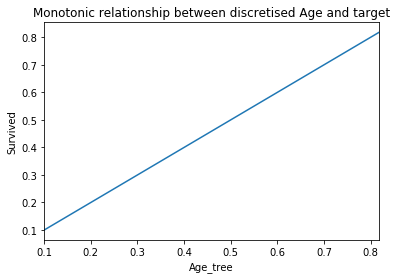

In [9]:
# monotonic relationship with target

fig = plt.figure()
fig = X_train.groupby(['Age_tree'])['Survived'].mean().plot()
fig.set_title('Monotonic relationship between discretised Age and target')
fig.set_ylabel('Survived')

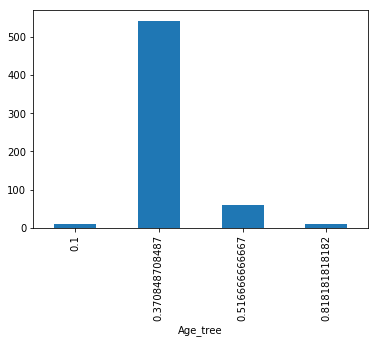

In [10]:
# number of passengers per probabilistic bucket / bin

X_train.groupby(['Age_tree'])['Survived'].count().plot.bar()

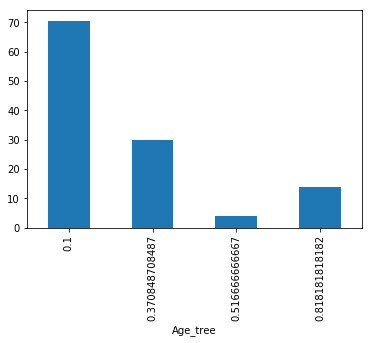

In [11]:
# median age within each bucket originated by the tree

X_train.groupby(['Age_tree'])['Age'].median().plot.bar()

In [12]:
# let's see the Age limits buckets generated by the tree
# by capturing the minimum and maximum age per each probability bucket, 
# we get an idea of the bucket cut-offs

pd.concat( [X_train.groupby(['Age_tree'])['Age'].min(),
            X_train.groupby(['Age_tree'])['Age'].max()], axis=1)

,Age,Age
Age_tree,,
0.100000,64.00,80.0
0.370849,16.00,63.0
0.516667,0.67,11.0
0.818182,12.00,15.0


Thus, the decision tree generated the buckets: 0-11, 12-15, 16-63 and 46-80, with probabilities of survival of .51, .81, .37 and .1 respectively.

### Tree visualisation

In [13]:
# we can go ahead and visualise the tree by saving the model to a file, and opening that file in the below indicated link

with open("tree_model.txt", "w") as f:
    f = export_graphviz(tree_model, out_file=f)

#http://webgraphviz.com

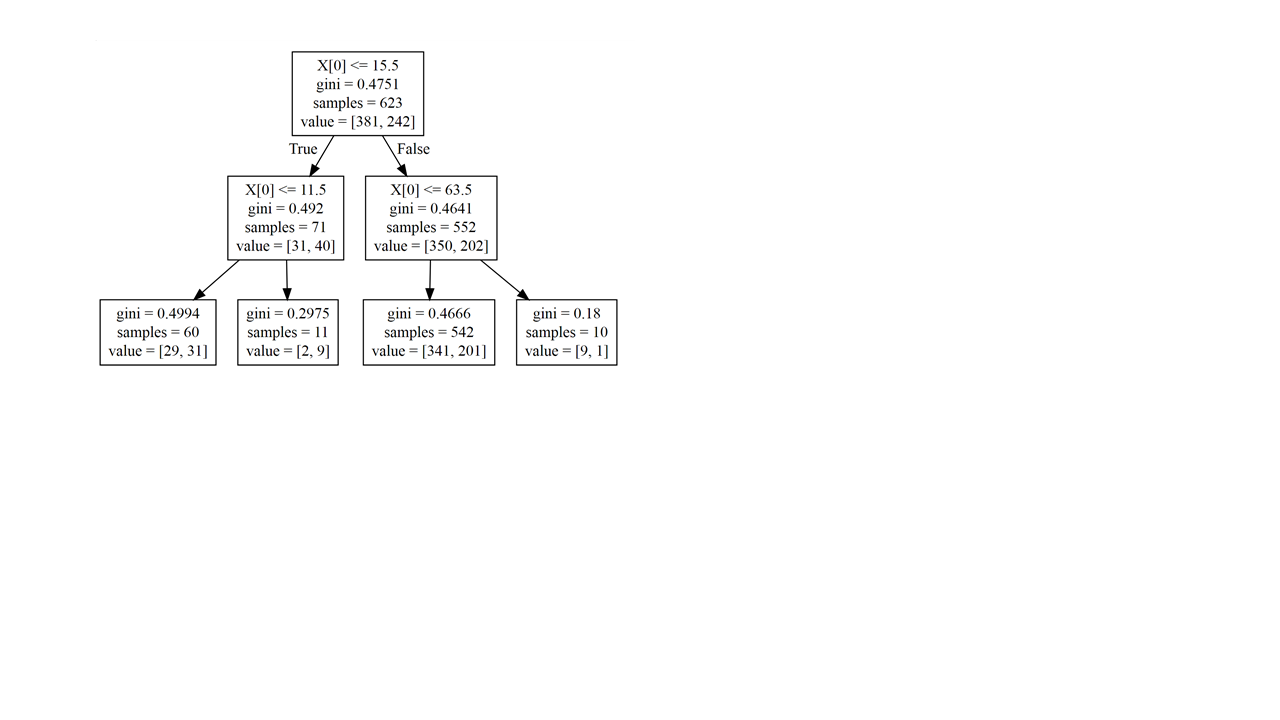

In [14]:
# this is what you should see if you do what is described in the previous cell
# the  plot indicates  the age cut-offs at each node, and also the number of samples at each node, and 
# the gini

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "tree_visualisation.png"
Image(filename = PATH , width=1000, height=1000)

### Select the optimal depth

As I mentioned earlier, there are a number of parameters that you could optimise to obtain the best bin split using decision trees. Below I will optimise the tree depth for a demonstration. But remember that you could also optimise the remaining parameters of the decision tree. Visit [sklearn website](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) to see which other parameters can be optimised.


In [15]:
# I will build trees of different depths, and I will calculate the roc-auc determined for the variable and
# the target for each tree
# I will then choose the depth that generates the best roc-auc

score_ls = [] # here I will store the roc auc
score_std_ls = [] # here I will store the standard deviation of the roc_auc

for tree_depth in [1,2,3,4]:
    # call the model
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)
    
    # train the model using 3 fold cross validation
    scores = cross_val_score(tree_model, X_train.Age.to_frame(), y_train, cv=3, scoring='roc_auc')
    score_ls.append(np.mean(scores))
    score_std_ls.append(np.std(scores))
    
temp = pd.concat([pd.Series([1,2,3,4]), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
temp

,depth,roc_auc_mean,roc_auc_std
0,1,0.524929,0.011327
1,2,0.522882,0.014414
2,3,0.517628,0.013480
3,4,0.518913,0.007791


We obtain the best roc-auc using depths of 1 or 2. I will select depth of 2 to proceed.

### Transform the feature using tree

In [16]:
tree_model = DecisionTreeClassifier(max_depth=2)
tree_model.fit(X_train.Age.to_frame(), X_train.Survived)
X_train['Age_tree'] = tree_model.predict_proba(X_train.Age.to_frame())[:,1]
X_test['Age_tree'] = tree_model.predict_proba(X_test.Age.to_frame())[:,1]

We are now ready to use those pre-processed Age features in machine learning algorithms. Why don't you go ahead and test them?

In [17]:
# let's inspect the transformed variables in train set
X_train.head()

,Age,Fare,Survived,Age_tree
857,51.0,26.5500,1,0.370849
52,49.0,76.7292,1,0.370849
386,1.0,46.9000,0,0.516667
124,54.0,77.2875,0,0.370849
578,14.5,14.4583,0,0.818182


In [18]:
# let's inspect the transformed variables in test set

X_test.head()

,Age,Fare,Survived,Age_tree
495,42.0,14.4583,0,0.370849
648,18.0,7.5500,0,0.370849
278,7.0,29.1250,0,0.516667
31,35.0,146.5208,1,0.370849
255,29.0,15.2458,1,0.370849


In [19]:
# and the unique values of each bin (train)
X_train.Age_tree.unique()

array([ 0.37084871,  0.51666667,  0.81818182,  0.1       ])

In [20]:
# and the unique values of each bin (test)

X_test.Age_tree.unique()

array([ 0.37084871,  0.51666667,  0.81818182,  0.1       ])

### Fare

### Select the optimal depth

Let's repeat the exercise with the variable Fare. Remember that fare was highly skewed and therefore would benefit from engineering to spread the information more evenly.

In [21]:
score_ls = []
score_std_ls = []
for tree_depth in [1,2,3,4]:
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)
    scores = cross_val_score(tree_model, X_train.Fare.to_frame(), y_train, cv=3, scoring='roc_auc')
    score_ls.append(np.mean(scores))
    score_std_ls.append(np.std(scores))
    
temp = pd.concat([pd.Series([1,2,3,4]), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
temp

,depth,roc_auc_mean,roc_auc_std
0,1,0.609106,0.023418
1,2,0.662132,0.026253
2,3,0.647950,0.045010
3,4,0.650984,0.035127


In this case, the best split roc_auc is obtained with a tree of depth 2, thus I will choose this one to proceed.

In [22]:
# train the decision tree and engineer Fare in train and test set
tree_model = DecisionTreeClassifier(max_depth=2)
tree_model.fit(X_train.Fare.to_frame(), X_train.Survived)
X_train['Fare_tree'] = tree_model.predict_proba(X_train.Fare.to_frame())[:,1]
X_test['Fare_tree'] = tree_model.predict_proba(X_test.Fare.to_frame())[:,1]

In [23]:
X_train['Fare_tree'].unique()

array([ 0.44230769,  0.74626866,  0.25531915,  0.10714286])

In [24]:
X_test['Fare_tree'].unique()

array([ 0.44230769,  0.25531915,  0.74626866,  0.10714286])

In [25]:
# let's see what are the Fare cut-offs within each bin
pd.concat( [X_train.groupby(['Fare_tree'])['Fare'].min(),
            X_train.groupby(['Fare_tree'])['Fare'].max()], axis=1)

,Fare,Fare
Fare_tree,,
0.107143,0.0000,7.5208
0.255319,7.5500,10.5000
0.442308,11.1333,73.5000
0.746269,75.2500,512.3292


The tree generated 4 bins: 0-7.5, 7.5-10.5, 11-73 and > 73, each with probability of survival .1, .25, .44 and .75 respectively. Indicating that people that paid higher fares, where more likely to survive. 

In [26]:
# and with this sequence of steps, we can visualise the tree

with open("tree_model.txt", "w") as f:
    f = export_graphviz(tree_model, out_file=f)

#http://webgraphviz.com

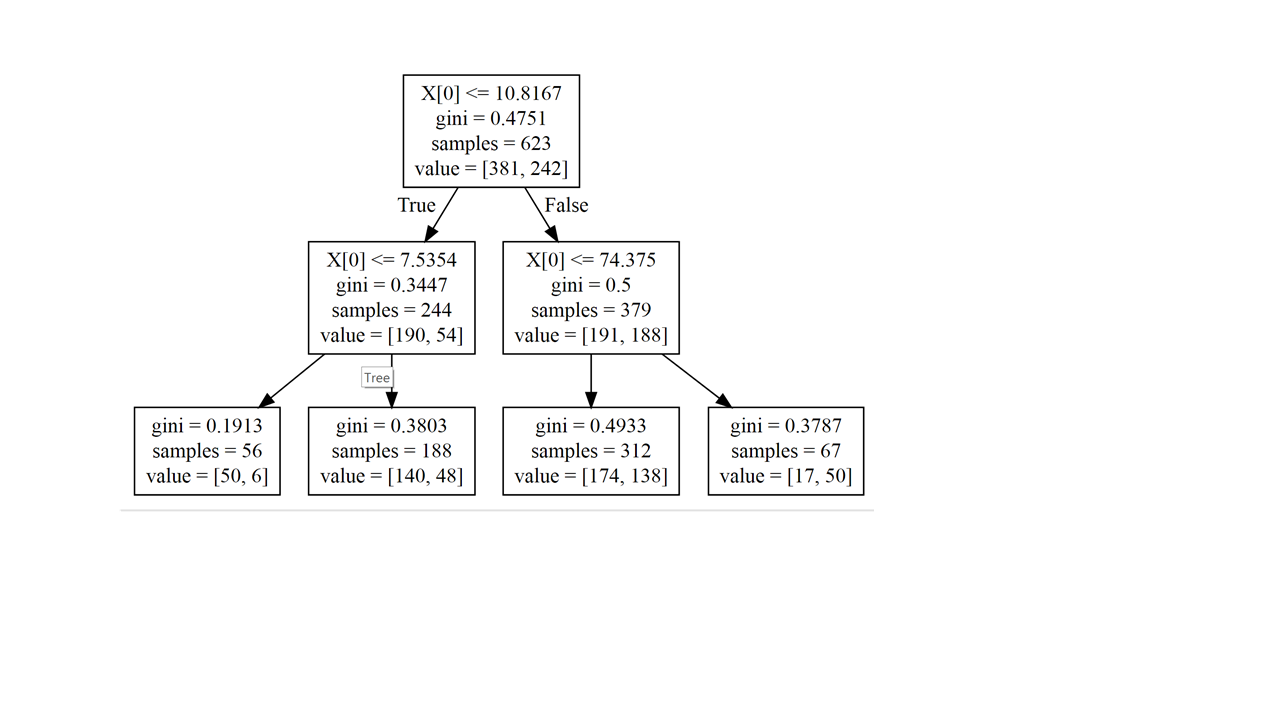

In [27]:
PATH = "tree_fare.png"
Image(filename = PATH , width=1000, height=1000)

## Discretisation with trees on categorical variables

Discretisation using trees can also be used on categorical variables, to capture some insight into how well they predict the target.

In [28]:
# let's load the categorical variable cabin from the titanic
data = pd.read_csv('titanic.csv', usecols=['Cabin', 'Survived'])

# let's fill na with a new category missing
data.Cabin.fillna('Missing', inplace=True)

# and let's capture just the first letter of the cabin, ignoring the number of the cabin
data['Cabin'] = data['Cabin'].astype(str).str[0]
data.head()

,Survived,Cabin
0,0,M
1,1,C
2,1,M
3,1,C
4,0,M


In [29]:
data.groupby('Cabin')['Survived'].count() / np.float(len(data))

Cabin
A    0.016835
B    0.052750
C    0.066218
D    0.037037
E    0.035915
F    0.014590
G    0.004489
M    0.771044
T    0.001122
Name: Survived, dtype: float64

We can see that cabins A, F, G and T show a low frequency of passengers, so I will re group them into a 'Rare' Category to avoid over-fitting.

In [30]:
data['Cabin'] = np.where(data.Cabin.isin(['A', 'F', 'G', 'T']), 'Rare', data.Cabin)

data.groupby('Cabin')['Survived'].count() / np.float(len(data))

Cabin
B       0.052750
C       0.066218
D       0.037037
E       0.035915
M       0.771044
Rare    0.037037
Name: Survived, dtype: float64

In [31]:
# lets replace the letters by numbers, without any sort of order

cabin_dict = {k:i for i, k in enumerate(data.Cabin.unique(), 0)} 
data.loc[:, 'Cabin'] = data.loc[:, 'Cabin'].map(cabin_dict)
data.head()

,Survived,Cabin
0,0,0
1,1,1
2,1,0
3,1,1
4,0,0


In [32]:
# let's inspect how the new cabin looks like
data.Cabin.unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

### Optimise depth

In [33]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data[['Cabin', 'Survived']], data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 2), (268, 2))

In [34]:
# and now we optimise a tree split on it as we did for numerical variables

score_ls = []
score_std_ls = []
for tree_depth in [1,2,3,4]:
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)
    scores = cross_val_score(tree_model, X_train.Cabin.to_frame(), y_train, cv=3, scoring='roc_auc')
    score_ls.append(np.mean(scores))
    score_std_ls.append(np.std(scores))
    
temp = pd.concat([pd.Series([1,2,3,4]), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
temp

,depth,roc_auc_mean,roc_auc_std
0,1,0.634922,0.021348
1,2,0.635294,0.022767
2,3,0.634844,0.020574
3,4,0.637038,0.020460


In [35]:
# I will proceed with depth = 2

tree_model = DecisionTreeClassifier(max_depth=2)
tree_model.fit(X_train.Cabin.to_frame(), X_train.Survived)
X_train['Cabin_tree'] = tree_model.predict_proba(X_train.Cabin.to_frame())[:,1]
X_test['Cabin_tree'] = tree_model.predict_proba(X_test.Cabin.to_frame())[:,1]

In [36]:
# the output creates 3 bins instead of 4, why is that?
X_train.Cabin_tree.unique()

array([ 0.6       ,  0.73684211,  0.30360934])

In [37]:
# the output creates 3 bins instead of 4, why is that?
X_test.Cabin_tree.unique()

array([ 0.30360934,  0.73684211,  0.6       ])

In [38]:
with open("tree_model.txt", "w") as f:
    f = export_graphviz(tree_model, out_file=f)

#http://webgraphviz.com

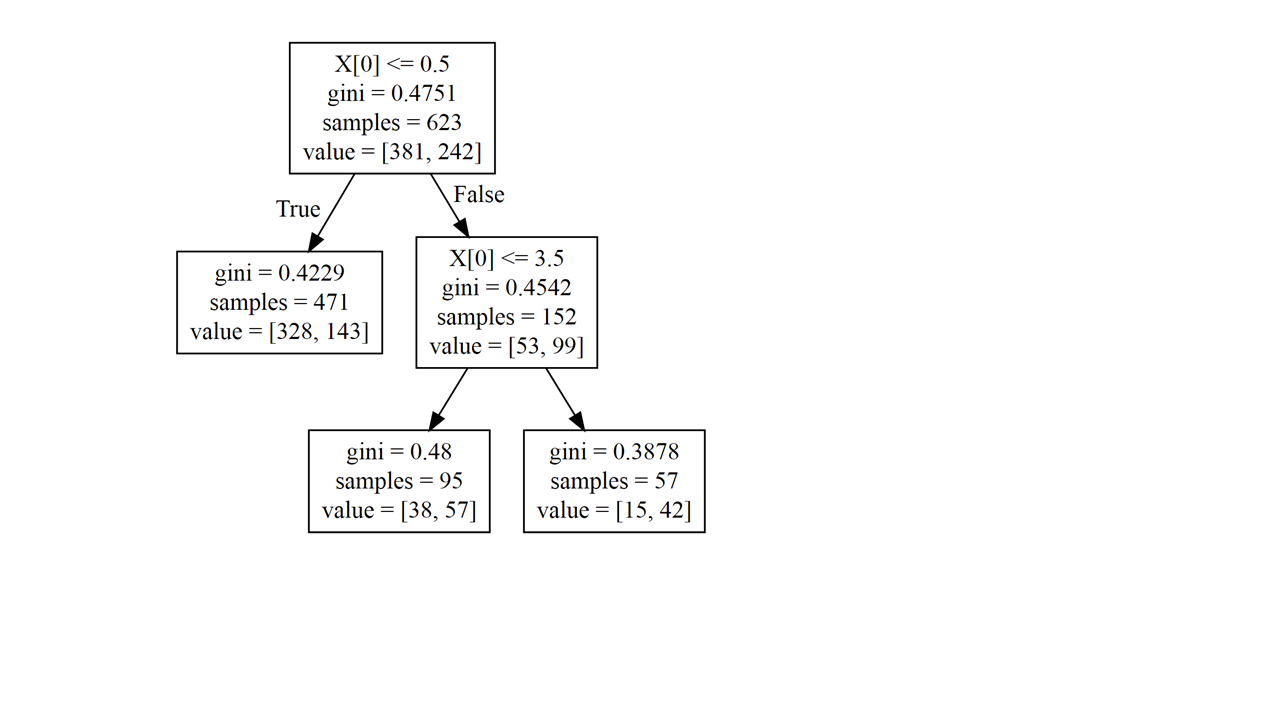

In [39]:
PATH = "tree_cabin.png"
Image(filename = PATH , width=1000, height=1000)

As we can see from the plot, we only obtain 3 bins, because the first split resulted already in a final node on the left.

In [40]:
# let's see what are the Fare cut-offs within each bin
pd.concat( [X_train.groupby(['Cabin_tree'])['Cabin'].min(),
            X_train.groupby(['Cabin_tree'])['Cabin'].max()], axis=1)

,Cabin,Cabin
Cabin_tree,,
0.303609,0,0
0.600000,1,3
0.736842,4,5


The decision tree has found these buckets as the optimal ones: Cabins 0, 1-3 and 4-5, with probability of survival .3, .6 and .73 respectively.

Amazing, no?

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**